In [463]:
import os
import re
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from timeit import default_timer as timer
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import kagglehub
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, roc_curve
from sklearn.utils.class_weight import compute_class_weight

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split
from tensorflow.keras.utils import to_categorical

# MAPPING DATASETS

In [80]:
# Map Kaggle labels to unified set
label_map = {
    "URTI": "URTI",
    "Healthy": "Healthy",
    "Asthma": "Asthma",
    "COPD": "COPD",
    "LRTI": "LRTI",
    "Pneumonia": "Pneumonia",
    "Bronchiectasis": "BRON",
    "Bronchiolitis": "BRON",
    "BRON": "BRON",
    "Lung Fibrosis":"Lung Fibrosis",
    "Plueral Effusion":"Plueral Effusion"
}

In [68]:
class Diagnosis():
  def __init__ (self, id, diagnosis, image_path):
    self.id = id
    self.diagnosis = diagnosis 
    self.image_path = image_path   

# CLEANING & PARSING: Mendeley Dataset

In [124]:
# extract labels for Mendeley dataset
path_mendeley = "audioDataMendeley/Audio files"

keep_upper = {"COPD", "BRON"}
diagnosis_list =[]

# Detect diagnosis text in the filename and format it properly.
def format_diagnosis_from_filename(filename):
    name, ext = os.path.splitext(filename)
    
    # Split on first underscore
    parts = name.split("_", 1)
    if len(parts) > 1:
        prefix, diag_segment = parts[0], parts[1]
        
        # Split the diagnosis segment by commas
        diag_parts = diag_segment.split(",")
        formatted_diag_parts = []
        for part in diag_parts:
            part_clean = part.strip()
            if part_clean.upper() in keep_upper:
                formatted_diag_parts.append(part_clean.upper())
            elif part_clean == "N":
                formatted_diag_parts.append("Healthy")
            else:
                formatted_diag_parts.append(part_clean.title())
        
        # Rejoin with commas
        new_diag_segment = ",".join(formatted_diag_parts)
        new_name = f"{prefix}_{new_diag_segment}"
    else:
        new_name = name
    
    return new_name + ext

# go through directory and only keep necessary files
mendeley_labels = []
data_mendeley = []
for c, file in enumerate(os.listdir(path_mendeley)):
    if file.endswith(".wav"):
        old_path = os.path.join(path_mendeley, file)

        if "heart failure" in file.lower() or "and" in file.lower():
            os.remove(old_path)
            continue

        new_filename = format_diagnosis_from_filename(file)
        new_path = os.path.join(path_mendeley, new_filename)
        
        # Rename the file
        os.rename(old_path, new_path)

        # make patient diagnosis csv
        filename_parts = new_filename.split("_")
        patient_id_pattern = r"\d+"

        # extract patient id and diagnosis from filename 
        match_id = re.search(patient_id_pattern,filename_parts[0])
        if match_id:
            patient_id_mendeley = int(match_id.group())

        diag_segment = filename_parts[1]
        patient_diagnosis_mendeley = diag_segment.split(",")[0].strip()
        
        data_mendeley.append([patient_id_mendeley,patient_diagnosis_mendeley])

        diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=patient_diagnosis_mendeley,
        image_path=new_path
    ))
        
# export csv
patient_diagnosis_df_mendeley = pd.DataFrame(data_mendeley)
patient_diagnosis_df_mendeley.to_csv('audioDataMendeley/patient_diagnosis.csv', index=False)

# PARSING DATASET: Kaggle

In [56]:
# Download latest version of the database 
path = kagglehub.dataset_download("vbookshelf/respiratory-sound-database")

print("Path to dataset files:", path)

Path to dataset files: /Users/katherinebeaty/.cache/kagglehub/datasets/vbookshelf/respiratory-sound-database/versions/2


In [125]:
# extract lables for kaggle dataset
# Path to patient diagnosis CSV
diagnosis_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv")

audio_path_kaggle = os.path.join(path, "Respiratory_Sound_Database/Respiratory_Sound_Database/audio_and_txt_files/")
files_kaggle = []
for file in os.listdir(audio_path_kaggle):
    if file.endswith(".wav"):
        files_kaggle.append(file)

files_kaggle = sorted(files_kaggle)

In [129]:
diag_dict_kaggle = { 101 : "URTI"}  
diagnosis_kaggle = pd.read_csv(diagnosis_path_kaggle)
  
for index , row in diagnosis_kaggle.iterrows():
    diag_dict_kaggle[row.iloc[0]] = row.iloc[1]

for c, f in enumerate(files_kaggle):
    patient_id = int(f.split('_')[0])
    raw_label = diag_dict_kaggle.get(patient_id, "Unknown")
    diagnosis_list.append(Diagnosis(
        id=c,
        diagnosis=label_map.get(raw_label, "Unknown"),
        image_path=join(audio_path_kaggle, f)
    ))

# FEATURE EXTRACTION

In [136]:
unique_labels = sorted(set(d.diagnosis for d in diagnosis_list))

# Create a mapping from label
one_hot_encoding = {label: idx for idx, label in enumerate(unique_labels)}
one_hot_encoding

{'Asthma': 0,
 'BRON': 1,
 'COPD': 2,
 'Healthy': 3,
 'LRTI': 4,
 'Lung Fibrosis': 5,
 'Plueral Effusion': 6,
 'Pneumonia': 7,
 'URTI': 8}

In [248]:
def audio_features(filename):
    sound, sample_rate = librosa.load(filename)
    stft = np.abs(librosa.stft(sound))  

    mfccs = np.mean(librosa.feature.mfcc(y=sound, sr=sample_rate, n_mfcc=40), axis=1)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=sound, sr=sample_rate), axis=1)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate), axis=1)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(sound), sr=sample_rate), axis=1)

    concat = np.concatenate((mfccs, chroma, mel, contrast, tonnetz))
    return concat

In [249]:
labels = []
wav_images =[]
features = []

for f in diagnosis_list:
    labels.append(one_hot_encoding[f.diagnosis]) 
    wav_images.append(audio_features(f.image_path))

/Users/katherinebeaty/Documents/DS340 Project/.venv/lib/python3.11/site-packages/librosa/core/pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


# PREPROCESSING

In [427]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(wav_images, labels, test_size=0.2, random_state=10)

# Convert to NumPy arrays
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Reshape for 1D CNN: (samples, sequence_length, channels)
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)


(1688, 193, 1) (1688,)
(422, 193, 1) (422,)


In [456]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 2, 1)  # (batch, channels, length)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)  # integer labels, not one-hot
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).permute(0, 2, 1)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create a dataset from training tensors
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

# Split into training + validation
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [457]:
# Create DataLoaders
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor),batch_size=batch_size, shuffle=False)

print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

Train samples: 1351
Validation samples: 337
Test samples: 422


In [458]:
print(X_train_tensor.shape)
print(y_train_tensor.shape) 

torch.Size([1688, 1, 193])
torch.Size([1688])


In [459]:
# compute the class weights to handle class imbalances
y_train_int = torch.tensor([np.argmax(y) if isinstance(y, (list, np.ndarray)) else y for y in y_train])  # integer labels
classes = torch.unique(y_train_int).numpy()
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_int.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Run Baisc Model

In [460]:
class CNN1Model(nn.Module):
    def __init__(self, n_classes=9):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.dropout1 = nn.Dropout(0.25)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout2 = nn.Dropout(0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 94, 128)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.dropout1(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [494]:
model = CNN1Model()
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
patience = 5
epochs_without_improve = 0
best_val_loss = float('inf')
train_losses, val_losses = [], []
train_f1, val_f1 = [], []
train_precision, val_precision = [], []
train_recall, val_recall = [], []

In [495]:
def get_metrics(model, loader, criterion, n_classes=9):
    model.eval()
    running_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            running_loss += loss.item()

            probs = F.softmax(output, dim=1)
            pred = output.argmax(dim=1)

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    all_targets_array = np.array(all_targets)
    all_preds_array = np.array(all_preds)
    all_probs_array = np.array(all_probs)

    # Compute metrics
    f1 = f1_score(all_targets_array, all_preds_array, average='macro',zero_division=0)
    precision = precision_score(all_targets_array, all_preds_array, average='macro',zero_division=0)
    recall = recall_score(all_targets_array, all_preds_array, average='macro',zero_division=0)
    
    avg_loss = running_loss / len(loader)

    return {
        "loss": avg_loss,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "preds": all_preds_array,
        "probs": all_probs_array,
        "targets": all_targets_array
    }

In [501]:
def train_model(model, train_loader, val_loader, test_loader, class_weights=None,lr=0.001, weight_decay=1e-4, n_classes=9, epochs=50, patience=5):
  criterion = nn.CrossEntropyLoss(weight=class_weights)
  optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
  best_val_f1 = 0
  epochs_without_improve = 0

  for epoch in range(epochs):
    model.train()
    for data, target in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()

    # Compute training metrics
    train_metrics = get_metrics(model, train_loader, criterion, n_classes)
    train_losses.append(train_metrics['loss'])
    train_f1.append(train_metrics['f1'])
    train_precision.append(train_metrics['precision'])
    train_recall.append(train_metrics['recall'])

    # Compute validation metrics 
    val_metrics = get_metrics(model, val_loader, criterion, n_classes=9)
    val_losses.append(val_metrics['loss'])
    val_f1.append(val_metrics['f1'])
    val_precision.append(val_metrics['precision'])
    val_recall.append(val_metrics['recall'])
    
    # Compute testing metrics
    test_metrics = get_metrics(model, test_loader, criterion, n_classes)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Training  - Loss: {train_metrics['loss']:.4f}, F1: {train_metrics['f1']:.3f}, "
          f"Precision: {train_metrics['precision']:.3f}, Recall: {train_metrics['recall']:.3f}")
    print(f"Validation    - Loss: {val_metrics['loss']:.4f}, F1: {val_metrics['f1']:.3f}, "
          f"Precision: {val_metrics['precision']:.3f}, Recall: {val_metrics['recall']:.3f}")
    print(f"Testing   - F1: {test_metrics['f1']:.3f}")
    print("------------------------")

    # Save best model based on validation F1
    if val_metrics['f1'] > best_val_f1:
      best_val_f1 = val_metrics['f1']
      torch.save(model.state_dict(), "best_model.pth")
      epochs_without_improve = 0
    else:
      epochs_without_improve += 1
      if epochs_without_improve >= patience:
        print("Early stopping triggered!")
        break
  print("Training complete. Best validation F1:", best_val_f1)

In [505]:
train_model(model, train_loader, val_loader, test_loader, class_weights=class_weights, epochs=50)

Epoch 1/50
Training  - Loss: 1.0206, F1: 0.273, Precision: 0.342, Recall: 0.664
Validation    - Loss: 1.2543, F1: 0.214, Precision: 0.204, Recall: 0.361
Testing   - F1: 0.204
------------------------
Epoch 2/50
Training  - Loss: 1.0665, F1: 0.369, Precision: 0.354, Recall: 0.662
Validation    - Loss: 1.2824, F1: 0.259, Precision: 0.297, Recall: 0.377
Testing   - F1: 0.216
------------------------
Epoch 3/50
Training  - Loss: 1.0805, F1: 0.279, Precision: 0.275, Recall: 0.653
Validation    - Loss: 1.2224, F1: 0.254, Precision: 0.232, Recall: 0.539
Testing   - F1: 0.219
------------------------
Epoch 4/50
Training  - Loss: 0.9938, F1: 0.300, Precision: 0.270, Recall: 0.681
Validation    - Loss: 1.1575, F1: 0.268, Precision: 0.260, Recall: 0.522
Testing   - F1: 0.248
------------------------
Epoch 5/50
Training  - Loss: 1.0268, F1: 0.284, Precision: 0.276, Recall: 0.630
Validation    - Loss: 1.2415, F1: 0.257, Precision: 0.277, Recall: 0.496
Testing   - F1: 0.206
------------------------


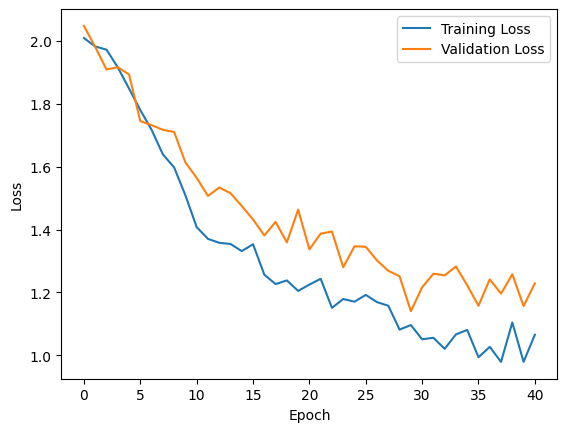

In [506]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

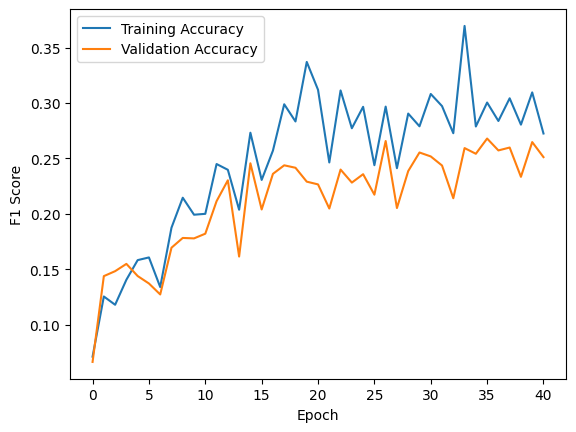

In [507]:
import matplotlib.pyplot as plt
plt.plot(train_f1, label='Training Accuracy')
plt.plot(val_f1, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

# EXPERIMENT 1: Audio Distortion

# EXPERIMENT 2: Training of specific locations